# Image Classification challange AN2DL Politecnico di Milano 2022
This is ..


## Define the environment
1. **Colab**: the notebook must be in a folder where there is a folder called `data` and the `zip` file containing the training data inside (i.e. `data/training_dataset_homework1.zip`).
2. **Local**: extract the `zip` file containing the training data in `data/training_data_final`

In [7]:
IS_COLAB = False
COLAB_BASE_DIR = '/gdrive/MyDrive/colab/AN2DL1/'
USE_WHOLE_DATASET = False # if True do not perform validation and analysis, just train with all the data

## Libraries import

In [8]:
import os
import enum
import json
from datetime import datetime
import random
from typing import Tuple, Callable, Dict, Optional, List

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Check device
tf.test.gpu_device_name()

''

### Seed

In [9]:
# Random seed for reproducibility
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED) 

### Mount Google Drive (if using Colab)

In [10]:
if IS_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')

### Check folders

In [11]:
ROOT_DIR = os.getcwd()
DATA_DIR = 'data/training_data_final'

if IS_COLAB:
  if not os.path.exists('data'):
    !mkdir 'data'
  if not os.path.isfile('data/training_dataset_homework1.zip'):
    zip_source = COLAB_BASE_DIR + 'data/training_dataset_homework1.zip'
    !cp $zip_source 'data'
  if not os.path.exists(DATA_DIR):
    !unzip 'data/training_dataset_homework1' -d 'data'
else:
  if not os.path.exists('data'):
    raise RuntimeError("data/training_data_final path not found.")
  if not os.path.exists(DATA_DIR):
    raise RuntimeError("please unzip data/training_dataset_homework1.zip")

## Load datasets

Define datasets hyperparameters

In [10]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64

In [11]:
IMG_SIZE = (96, 96)
IMG_SHAPE = IMG_SIZE + (3,)
N_CLASSES = 8

if USE_WHOLE_DATASET:
    complete_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=SEED,
    )
else:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=SEED,
        validation_split=VALIDATION_SPLIT,
        subset = 'training'
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=SEED,
        validation_split=VALIDATION_SPLIT,
        subset = 'validation'
    )

Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


Configure the dataset for performance, see the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide:

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

if USE_WHOLE_DATASET:
  complete_ds = complete_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
else:
  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Preprocessing and Data Augmentation

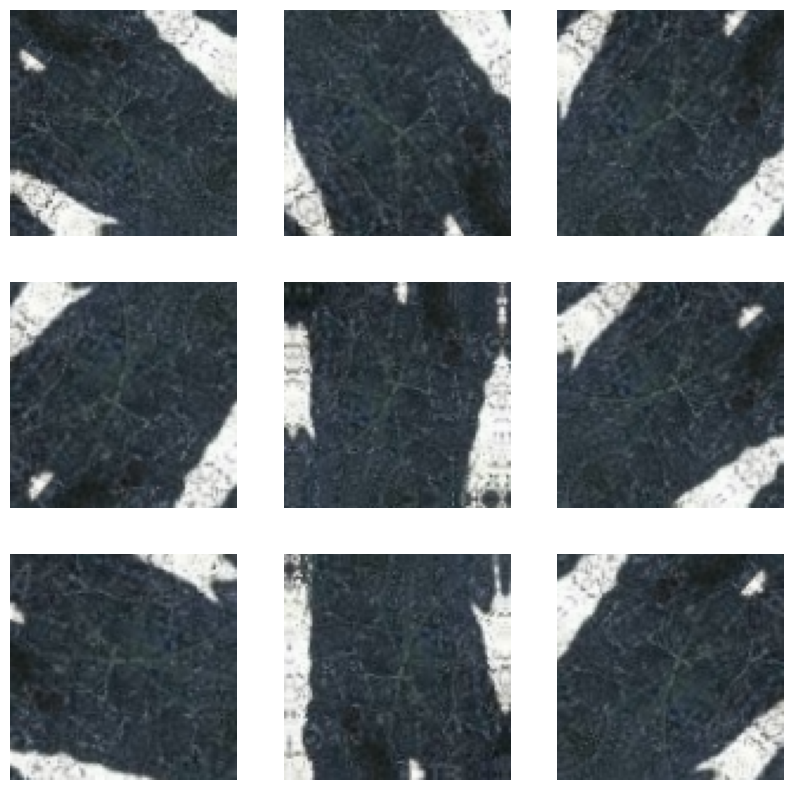

In [13]:
data_augmentation_layer = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomContrast(0.1), this makes the training 10x slower
  #tf.keras.layers.RandomBrightness(0.01),
  tf.keras.layers.RandomZoom(0.1),
  #tf.keras.layers.RandomTranslation(0.1, 0.1)
], name='data_augmentation')

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation_layer(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Model

In [14]:
if USE_WHOLE_DATASET:
  model_EPOCHS = 39

model_LEARNING_RATE = 1e-3
model_OPTIMIZER = tf.keras.optimizers.Adam(model_LEARNING_RATE)
model_LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
model_EARLY_STOPPING_PATIENCE = 10

In [15]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE, name="input"),
    data_augmentation_layer,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3, 3), (1, 1), padding='same', activation='relu', kernel_initializer = tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, (3, 3), (1, 1), padding='same', activation='relu', kernel_initializer = tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, (3, 3), (1, 1), padding='same', activation='relu', kernel_initializer = tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(256, (3, 3), (1, 1), padding='same', activation='relu', kernel_initializer = tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(512, (3, 3), (1, 1), padding='same', activation='relu', kernel_initializer = tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(N_CLASSES, name='output', activation='softmax', kernel_initializer=tf.keras.initializers.GlorotUniform(SEED))
], name="CNN-VVG16-inspired")

In [16]:
model.compile(
    optimizer=model_OPTIMIZER,
    loss=model_LOSS,
    metrics=['accuracy']
)
model.summary()

Model: "CNN-VVG16-inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 96, 96, 3)        0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)

In [17]:
train_sb_images, train_sb_labels = next(iter(train_ds))
val_sb_images, val_sb_labels = next(iter(val_ds))

overfit_single_batch = model.fit(
    train_sb_images,
    train_sb_labels,
    use_multiprocessing=True,
    epochs=50,
    verbose=2,  
    validation_data=(val_sb_images, val_sb_labels),
    shuffle=True
)

Epoch 1/50
2/2 - 5s - loss: 7.9440 - accuracy: 0.1719 - val_loss: 9.7193 - val_accuracy: 0.1406 - 5s/epoch - 2s/step
Epoch 2/50
2/2 - 1s - loss: 6.7553 - accuracy: 0.1250 - val_loss: 2.8420 - val_accuracy: 0.1562 - 875ms/epoch - 437ms/step
Epoch 3/50
2/2 - 1s - loss: 2.5852 - accuracy: 0.1562 - val_loss: 2.0867 - val_accuracy: 0.1406 - 876ms/epoch - 438ms/step
Epoch 4/50
2/2 - 1s - loss: 2.0508 - accuracy: 0.1562 - val_loss: 2.1445 - val_accuracy: 0.1094 - 937ms/epoch - 469ms/step
Epoch 5/50
2/2 - 1s - loss: 1.9671 - accuracy: 0.2656 - val_loss: 2.1651 - val_accuracy: 0.1094 - 902ms/epoch - 451ms/step
Epoch 6/50
2/2 - 1s - loss: 1.9141 - accuracy: 0.2656 - val_loss: 2.1279 - val_accuracy: 0.1094 - 891ms/epoch - 445ms/step
Epoch 7/50
2/2 - 1s - loss: 1.9004 - accuracy: 0.2656 - val_loss: 2.1425 - val_accuracy: 0.1094 - 940ms/epoch - 470ms/step
Epoch 8/50
2/2 - 1s - loss: 1.8788 - accuracy: 0.3125 - val_loss: 2.1676 - val_accuracy: 0.1094 - 862ms/epoch - 431ms/step
Epoch 9/50
2/2 - 1s - 

### Training

In [18]:
if USE_WHOLE_DATASET:
  model_history = model.fit(
    complete_ds,
    epochs=model_EPOCHS
  )
else:
  # use early stopping
  model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=model_EARLY_STOPPING_PATIENCE, restore_best_weights=True)
  model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks = [model_early_stopping],
  )

Epoch 1/100
45/45 [==============================] - 38s 807ms/step - loss: 1.7526 - accuracy: 0.3691 - val_loss: 2.5264 - val_accuracy: 0.2528
Epoch 2/100
30/45 [===================>..........] - ETA: 13s - loss: 1.5021 - accuracy: 0.4488

KeyboardInterrupt: 

### Visualize performance

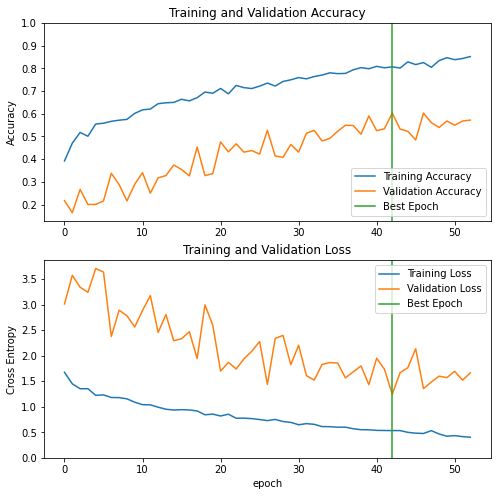

In [ ]:
acc = model_history.history['accuracy']
if not USE_WHOLE_DATASET:
  val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
if not USE_WHOLE_DATASET:
  val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
if not USE_WHOLE_DATASET:
  plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
if not USE_WHOLE_DATASET:
  plt.plot([model_early_stopping.best_epoch,model_early_stopping.best_epoch], plt.ylim(), label='Best Epoch')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
if not USE_WHOLE_DATASET:
  plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,max(plt.ylim())])
if not USE_WHOLE_DATASET:
  plt.plot([model_early_stopping.best_epoch,model_early_stopping.best_epoch], plt.ylim(), label='Best Epoch')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save model

In [ ]:
model_directory = f'models/{model.name}-finetuned-{datetime.today().strftime("%Y-%m-%d-%H-%M-%S")}'
model.save(model_directory)
if IS_COLAB:
  from shutil import make_archive, copyfile
  make_archive(model_directory, 'zip', model_directory)
  copyfile(model_directory + '.zip', COLAB_BASE_DIR + model_directory + '.zip')